## Parameter recovery for interaction between model parameter and a between-subjects regressor

This notebook is slightly modified from the `.py` posted by Michael, see [here](https://groups.google.com/g/hddm-users/c/C96uz2_xFl8) for the discussion.


In [1]:
import hddm
from numpy import mean, std
import numpy as np         
from pandas import Series
import pandas as pd
import os as os
import matplotlib.pyplot as plt

# os.chdir('/storage/home/mnh5174')


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


### Stimulation with between-within interaction


#### Generate data

Here we simulate the interaction between between-subject regressor and within subject variable

$a$ interacts with different levels, e.g., level 1 is $$ a_1 = int_{a} + \beta_{a1} * X $$, and level 2 is $$ a_2 = int_{a} + \beta_{a2} * X $$?

In [2]:
beta_a1 = 0.4   # between subjects scaling factor - adjust this and should be able to recover its true value
beta_a2 = 0.1
a_int = 1      # set intercept within range of empirical priors 
v_int = 0.3
x_range = range(11)   # set values of between subject measures, here from 0 to 10
trials_per_level = 100    
subjs_per_bin = 10

data_group = pd.DataFrame()  # empty df to append to  

for x in x_range:
    xx = (x - mean(x_range)) / std(x_range)  # z-score the x factor
    a1 = a_int + beta_a1 * xx  #  indiv subj param values that are centered on intercept but deviate from it up or down by z-scored x
    a2 = a_int + beta_a2 * xx 
    # v = v_int+ beta_a*xx  # can also do for drift, here using same beta coeff
    
    parvec = {'v':.3, 'a':a1, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    parvec2 = {'v':.3, 'a':a2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    # parvec = {'v':.3, 'a':a, 't':.3}  # set a to value set by regression, here v is set to constant

    # note that for subjs_per_bin > 1, these are just the mean values of the parameters; indiv subjs within bin are sampled from distributions with the given means, but can still differ within bin around those means. 
    #not including sv, sz, st in the statement ensures those are actually 0.

    # data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec}, size=trials_per_level, subjs=subjs_per_bin)
    
    # can also do with two levels of within-subj conditions
    data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec,'level2': parvec2}, size=trials_per_level, subjs=subjs_per_bin)

    data_a['z_x'] = Series(xx * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['x'] = Series(x * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    #data_a['a_population'] = Series(a * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['a_population'] = Series(a1 * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a.loc[data_a['condition'] == 'level2', 'a_population'] = a2
    data_a['subj_idx'] = Series(x * subjs_per_bin + data_a['subj_idx'] * np.ones((len(data_a))), index=data_a.index)  # store the correct subj_idx when iterating over multiple subjs per bin
     
    # concatenate data_a with group data
    data_a_df = pd.DataFrame(data=[data_a])
    data_group = data_group.append([data_a], ignore_index=True)

#write original simulated data to file
data_group.to_csv('data_group_int.csv')

Plot the correlations

Text(0, 0.5, 'simulated a')

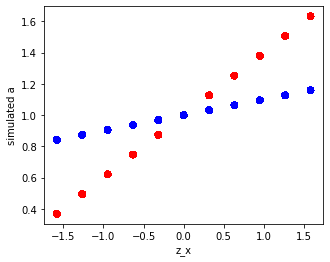

In [3]:
colors = np.where(data_group["condition"]== 'level1','r','b')
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(data_group.z_x,data_group.a_population, c=colors) # predicted versus observed a
plt.xlabel('z_x')
plt.ylabel('simulated a')

#### Recovery of parameters

In [4]:
# a_reg_within = {'model': 'a ~ 1+x + C(condition)', 'link_func': lambda x: x}
# for including and estimating within subject effects of  condition

# try main effect of within and interaction between within and between-subject
a_reg = {'model': 'a ~ 1 + z_x:condition + C(condition)', 'link_func': lambda x: x}

v_reg = {'model': 'v ~ 1 + z_x:condition + C(condition)', 'link_func': lambda x: x}
reg_comb = [a_reg, v_reg]
# m_reg = hddm.HDDMRegressor(data_group, reg_comb, group_only_regressors=['true']) 

# Do not estimate individual subject parameters for all regressors.
m_reg = hddm.HDDMRegressor(data_group, a_reg, group_only_regressors=['true'])
m_reg.find_starting_values()
m_reg.sample(2000, burn=500, dbname='a_bwsubs_int.db', db='pickle')
m_reg.save('a_bwsubs_int')

m_reg.print_stats()  # check values of reg coefficients against the generated ones

Adding these covariates:
['a_Intercept', 'a_C(condition)[T.level2]', 'a_z_x:condition[level1]', 'a_z_x:condition[level2]']


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 5086.6 secWARNING: Will not save custom link functions.
                              mean       std      2.5q       25q       50q       75q     97.5q    mc err
v                         0.263963  0.051193  0.163020  0.229199  0.265033  0.298121  0.365761  0.001557
v_std                     0.503298  0.039310  0.431660  0.475906  0.501106  0.529267  0.587288  0.001389
v_subj.0.0               -0.396460  0.244446 -0.871081 -0.558651 -0.400715 -0.230054  0.098695  0.006313
v_subj.1.0                0.314361  0.165800 -0.007304  0.200257  0.311569  0.431449  0.627450  0.003962
v_subj.2.0                0.096469  0.186849 -0.276317 -0.027089  0.094702  0.224406  0.451081  0.005424
v_subj.3.0                0.425301  0.157420  0.125339  0.322341  0.423111  0.528547  0.743254  0.004196
v_subj.4.0                0.405585  0.206461  0.022155  0.266983  0.405336  0.535019  0.821592  0.004620
v_subj.5.0                0.500010  0

Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_C(condition)[T.level2]
Plotting a_z_x:condition[level1]
Plotting a_z_x:condition[level2]


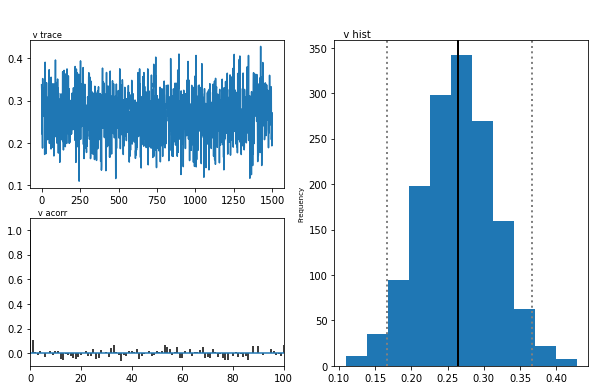

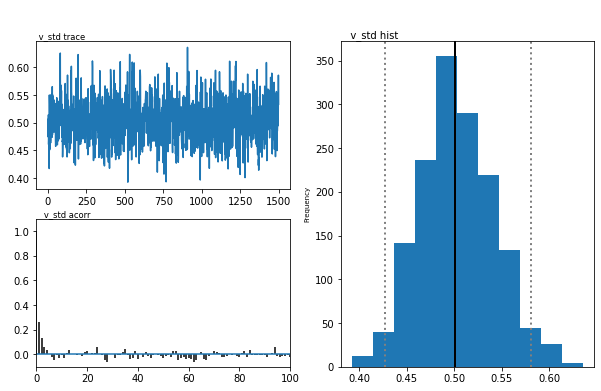

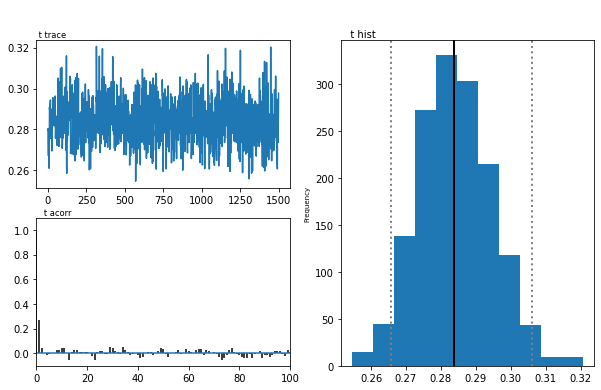

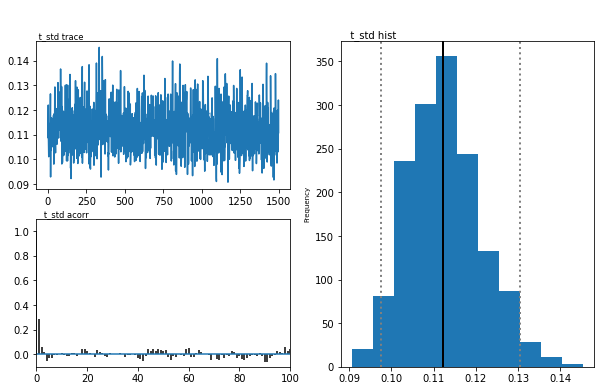

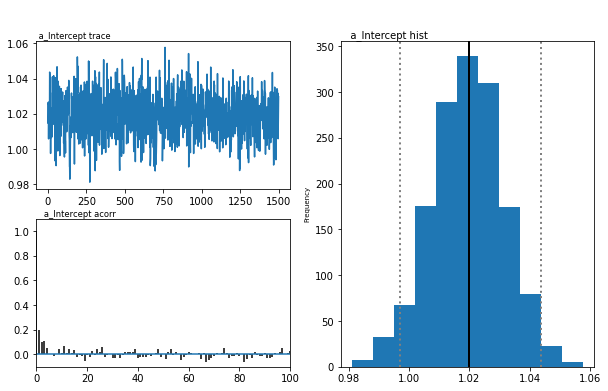

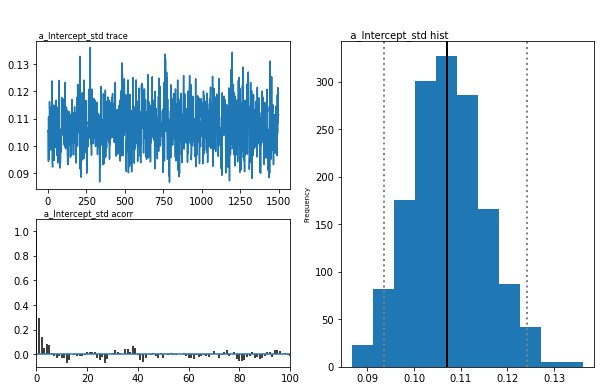

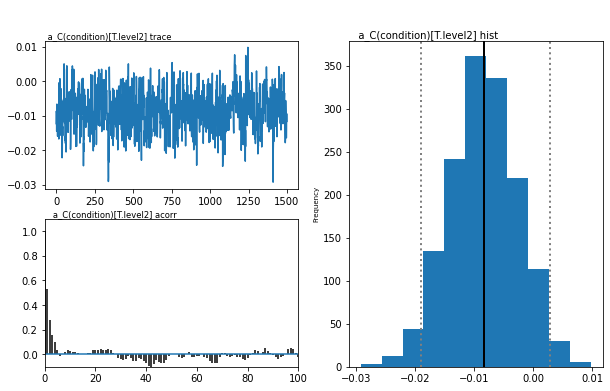

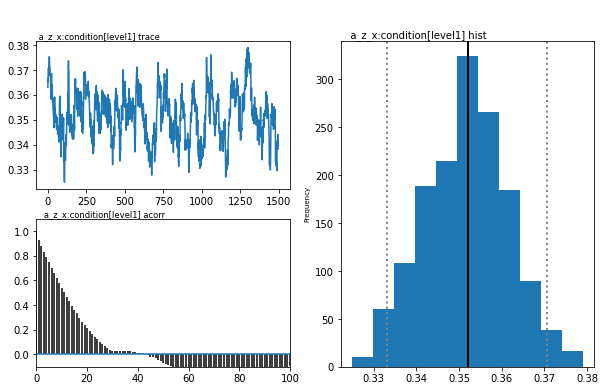

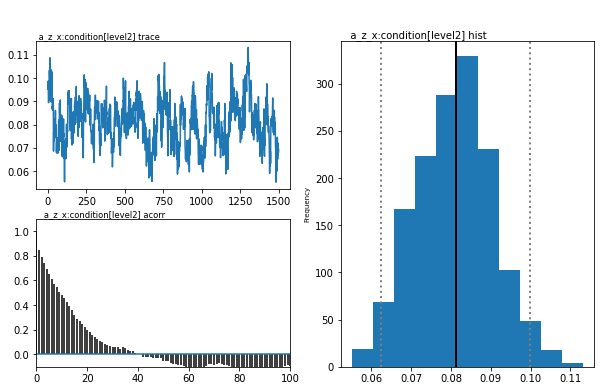

In [6]:
m_reg.plot_posteriors()

In [7]:
#load from file and examine recovery
m_reg = hddm.load('a_bwsubs_int')
data_group = pd.read_csv('data_group_int.csv')

#look at correlation of recovered parameter with original
subjdf = data_group.groupby(['subj_idx','condition']).first().reset_index()

In [8]:
## check for residual correlation with x 
a_int_recovered =[]

# obtain mean a intercept parameter for subjects
from scipy import stats
for i in range(0,(1+max(x_range))*subjs_per_bin):
    a='a_Intercept_subj.'
    a+=str(i)
    a+='.0'
    p1=m_reg.nodes_db.node[a] 
    a_int_recovered.append(p1.trace().mean())
    a_int_recovered.append(p1.trace().mean()) # repeat the intercept one more time for the level2
    

#obtain mean a regression weight for z_x
#a_x_recovered = m_reg.nodes_db.node['a_z_x'].trace().mean()

#obtain mean a regression weight for z_x  (slope)

a_x_recovered_1 = m_reg.nodes_db.node['a_z_x:condition[level1]'].trace().mean()
a_x_recovered_2 = m_reg.nodes_db.node['a_z_x:condition[level2]'].trace().mean()

In [9]:
#compute predicted a parameter as a function of subject intercept and between-subjects regressor
# subjdf['a_int_recovered'] = a_int_recovered
subjdf.loc[subjdf['condition'] == 'level1', 'apred'] = a_int_recovered + a_x_recovered_1 * subjdf.z_x
subjdf.loc[subjdf['condition'] == 'level2', 'apred'] = a_int_recovered + a_x_recovered_2 * subjdf.z_x

Pearson correlation between a_x and x
(0.9624233100108291, 5.714110525972471e-63)


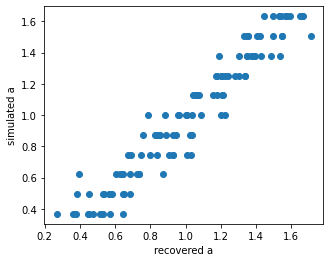

In [10]:
# correlation of recovered a with population a. r = .97 here: good!
subjdf1 = subjdf[subjdf['condition']=='level1']
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf1.apred,subjdf1.a_population) # predicted versus observed a
plt.xlabel('recovered a')
plt.ylabel('simulated a')
# plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(subjdf1.apred,subjdf1.a_population)) # correlation between predicted a value and population a value

Pearson correlation between a_x and x
(0.6347282986263716, 9.622586001495305e-14)


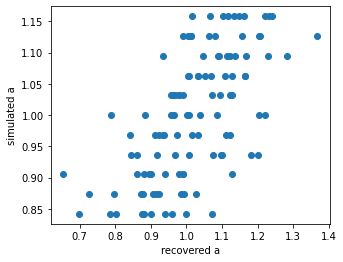

In [11]:
# correlation of recovered a with population a. r = .97 here: good!
subjdf2 = subjdf[subjdf['condition']=='level2']
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf2.apred,subjdf2.a_population) # predicted versus observed a
plt.xlabel('recovered a')
plt.ylabel('simulated a')
#plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(subjdf2.apred,subjdf2.z_x)) # correlation between predicted a value and population a value

Text(0.5, 0, 'z_x')

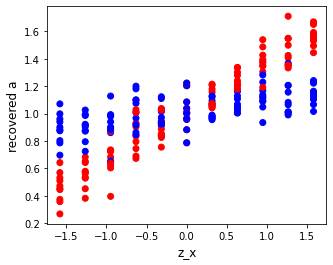

In [12]:
colors = np.where(subjdf["condition"]== 'level1','r','b')
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(x=subjdf['z_x'], y=subjdf['apred'], c=colors)
ax.set_ylabel('recovered a', fontsize=12)
ax.set_xlabel('z_x', fontsize=12)
#ax.set_title(f'Group: {idx}', fontsize=14)


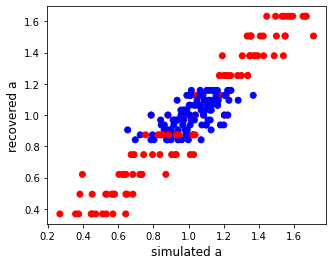

In [17]:
colors = np.where(subjdf["condition"]== 'level1','r','b')
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(x=subjdf['apred'], y=subjdf['a_population'], c=colors)
ax.set_ylabel('recovered a', fontsize=12)
ax.set_xlabel('simulated a', fontsize=12)
#ax.set_title(f'Group: {idx}', fontsize=14)
plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')

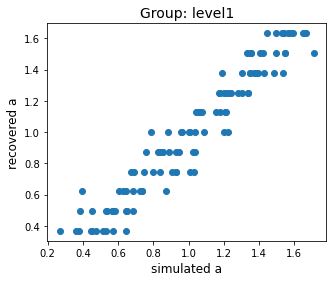

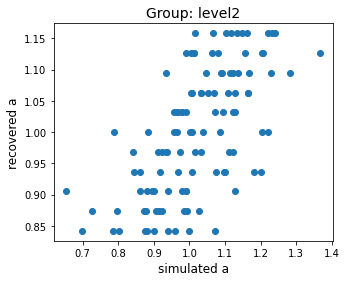

<Figure size 432x288 with 0 Axes>

In [18]:
for idx, gp in subjdf.groupby('condition'):
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(x=gp['apred'], y=gp['a_population'])
    
    ax.set_ylabel('recovered a', fontsize=12)
    ax.set_xlabel('simulated a', fontsize=12)
    ax.set_title(f'Group: {idx}', fontsize=14)
    
    plt.show()



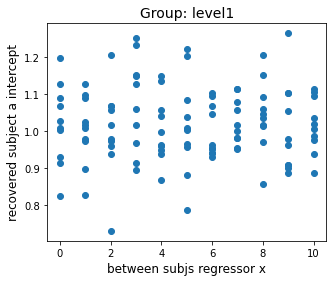

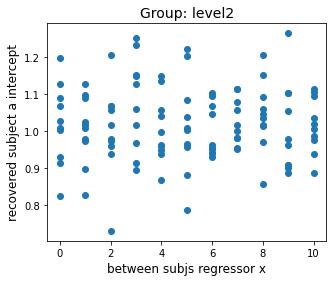

In [16]:
# correlation of subject intercept with between-subjects regressor
# should be zero correlation if entirely accounted for by x regressor - 
# this correlation should instead be positive if x is removed from the model fit
subjdf['a_int_recovered'] = a_int_recovered
for idx, gp in subjdf.groupby('condition'):
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(x=gp['x'], y=gp['a_int_recovered'])
    
    ax.set_xlabel('between subjs regressor x', fontsize=12)
    ax.set_ylabel('recovered subject a intercept', fontsize=12)
    ax.set_title(f'Group: {idx}', fontsize=14)
    
    plt.show()